In [70]:
from cyvcf2 import VCF
import pandas as pd

# ✅ 1. Load the VCF file
vcf_file = "Indigen_Alu_final_geno10_all_22K.vcf"
vcf = VCF(vcf_file)

# ✅ 2. Get sample names from header
samples = vcf.samples

# ✅ 3. Initialize storage
variant_ids = []
genotype_matrix = []

# ✅ 4. Loop through each variant
for i, variant in enumerate(vcf):
    # Optional: Limit to first 500 variants to test
    # if i >= 500:
    #     break
    
    # Build unique variant ID: chr_position
    variant_id = f"{variant.CHROM}_{variant.POS}"
    variant_ids.append(variant_id)

    # Extract genotype: 0|1 → 1 (het), 1|1 → 2, 0|0 → 0, ./ → -1
    encoded = []
    for gt in variant.genotypes:  # Format: [allele1, allele2, phased]
        a1, a2 = gt[0], gt[1]
        if a1 == -1 or a2 == -1:
            encoded.append(-1)  # missing
        else:
            encoded.append(a1 + a2)  # 0, 1, 2
    genotype_matrix.append(encoded)

# ✅ 5. Build DataFrame
df = pd.DataFrame(genotype_matrix, index=variant_ids, columns=samples).T
df.index.name = "Sample_ID"
df.reset_index(inplace=True)

# ✅ 6. Save for ML/EDA
df.to_csv("genotype_matrix.csv", index=False)
print(df.shape)
df.head()

(1021, 21982)


,Sample_ID,1_710591,1_1188985,1_1366575,1_2213750,1_2231056,1_2519119,1_3737487,1_4011935,1_4060134,...,Y_19791034,Y_20412626,Y_21146164,Y_21212065,Y_26669004,Y_26671551,Y_56684157,Y_56706604,Y_56742659,Y_56881336
0,IND1,1,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,1,1,2,1,1,1
1,IND2,2,0,0,0,0,0,0,0,0,...,1,0,0,0,-1,-1,-1,-1,-1,1
2,IND3,2,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,1,-1,1,1,1
3,IND4,0,0,0,0,0,0,0,0,1,...,1,0,0,0,-1,-1,-1,-1,-1,1
4,IND5,2,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,1,1,1,1,1,1


In [71]:
import pandas as pd

# Load genotype matrix
geno = pd.read_csv("genotype_matrix.csv").set_index("Sample_ID")

# Optional: Handle missing values (e.g., -1 encoded for ./.)
geno = geno.replace(-1, pd.NA).dropna(axis=1, thresh=int(0.95 * len(geno)))
geno = geno.fillna(0)  # or impute

/var/folders/xr/mk4d4gxj4xlbfps4j970493w0000gn/T/ipykernel_27622/619227249.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  geno = geno.fillna(0)  # or impute


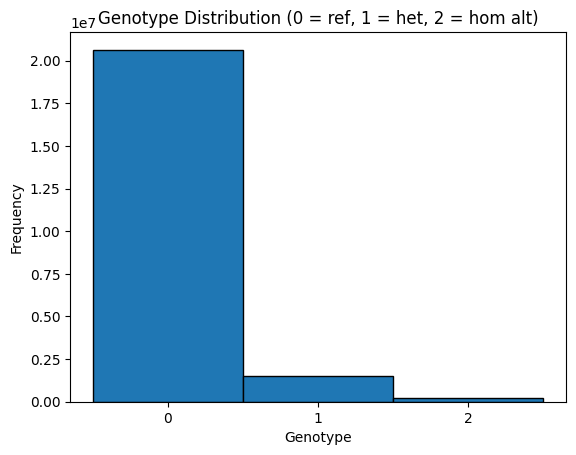

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of genotypes
geno_values = geno.values.flatten()
plt.hist(geno_values, bins=[-0.5, 0.5, 1.5, 2.5], edgecolor='black')
plt.xticks([0, 1, 2])
plt.title("Genotype Distribution (0 = ref, 1 = het, 2 = hom alt)")
plt.xlabel("Genotype")
plt.ylabel("Frequency")
plt.show()

# Missing rate per sample (before fillna)
# geno.replace(-1, pd.NA).isna().mean(axis=1).plot.hist()

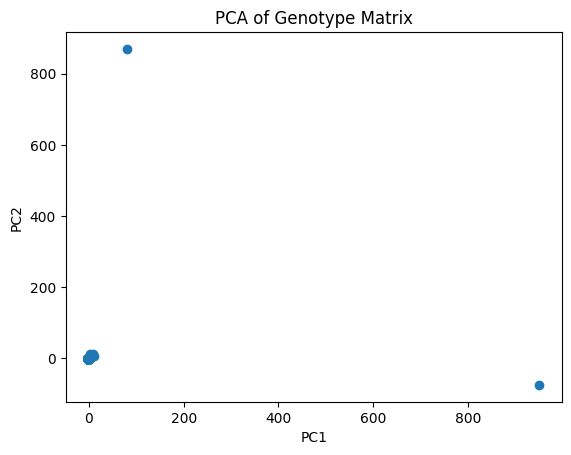

In [73]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(geno)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA of Genotype Matrix")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

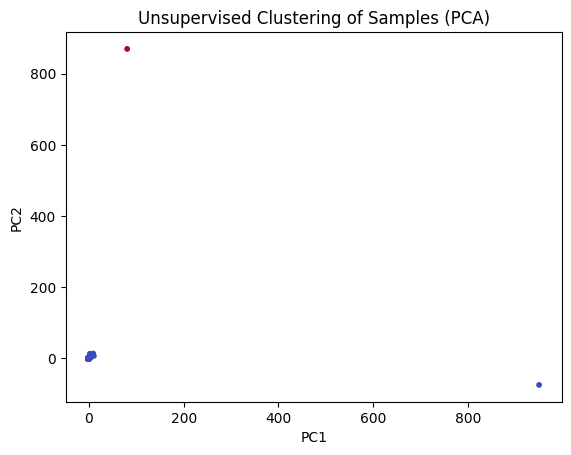

In [74]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add cluster labels
geno_clustered = geno.copy()
geno_clustered["Cluster"] = clusters

# Plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="coolwarm", s=10)
plt.title("Unsupervised Clustering of Samples (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

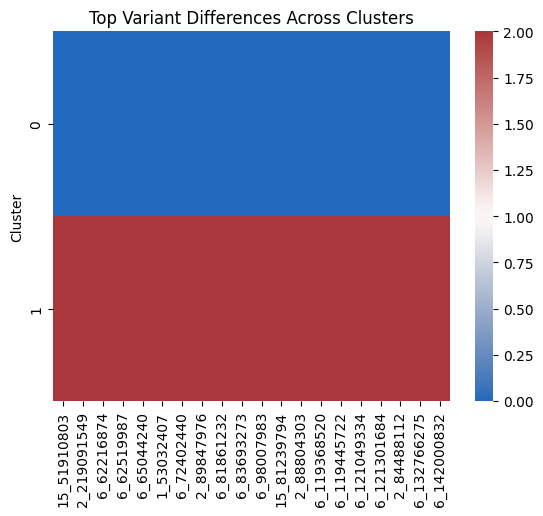

In [75]:
# Mean genotype values per variant across clusters
cluster_means = geno_clustered.groupby("Cluster").mean()
cluster_diff = cluster_means.max() - cluster_means.min()

# Top 20 divergent variants
important_variants = cluster_diff.sort_values(ascending=False).head(20)
important_variants.to_csv("top_variant_differences_per_cluster.csv")

# Heatmap
sns.heatmap(geno_clustered[important_variants.index].groupby(geno_clustered["Cluster"]).mean(), cmap="vlag")
plt.title("Top Variant Differences Across Clusters")
plt.show()

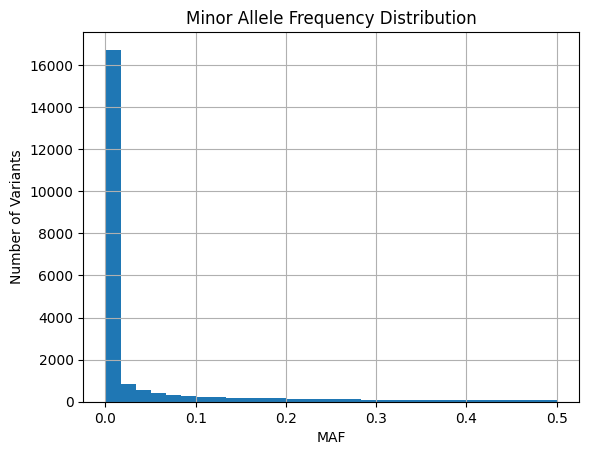

count    21896.000000
mean         0.039064
std          0.093428
min          0.000490
25%          0.000490
50%          0.000979
75%          0.013222
max          0.500000
dtype: float64

In [76]:
# Calculate MAF per variant
def maf(col):
    # Assuming diploid, total allele count = 2 * non-missing samples
    valid = col[col != -1]
    if len(valid) == 0: return None
    alt_alleles = valid.sum()
    total_alleles = 2 * len(valid)
    return min(alt_alleles / total_alleles, 1 - (alt_alleles / total_alleles))

maf_series = geno.apply(maf, axis=0)
maf_series.hist(bins=30)
plt.title("Minor Allele Frequency Distribution")
plt.xlabel("MAF")
plt.ylabel("Number of Variants")
plt.show()

maf_series.describe()

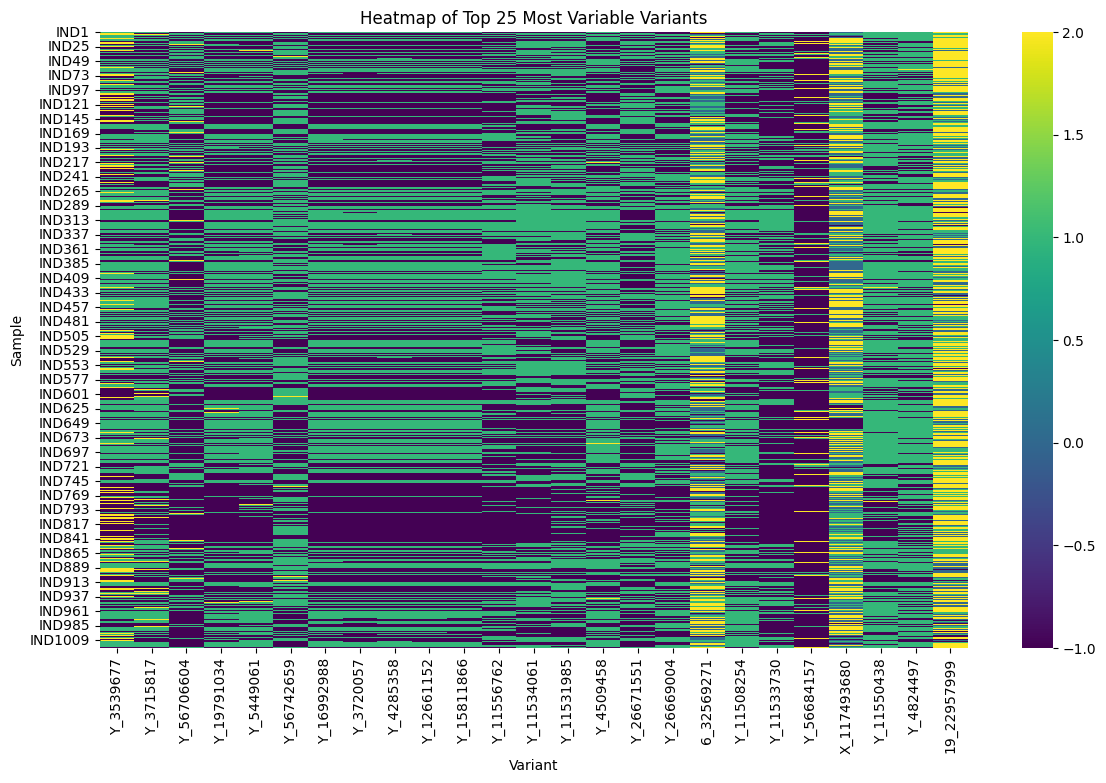

In [77]:
top_variants = X.std().sort_values(ascending=False).head(25).index
plt.figure(figsize=(14, 8))
sns.heatmap(X[top_variants], cmap="viridis", cbar=True)
plt.title("Heatmap of Top 25 Most Variable Variants")
plt.xlabel("Variant")
plt.ylabel("Sample")
plt.show()

/var/folders/xr/mk4d4gxj4xlbfps4j970493w0000gn/T/ipykernel_27622/2132093258.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_viz, x="Cluster", y=top_variant, palette="Set2")


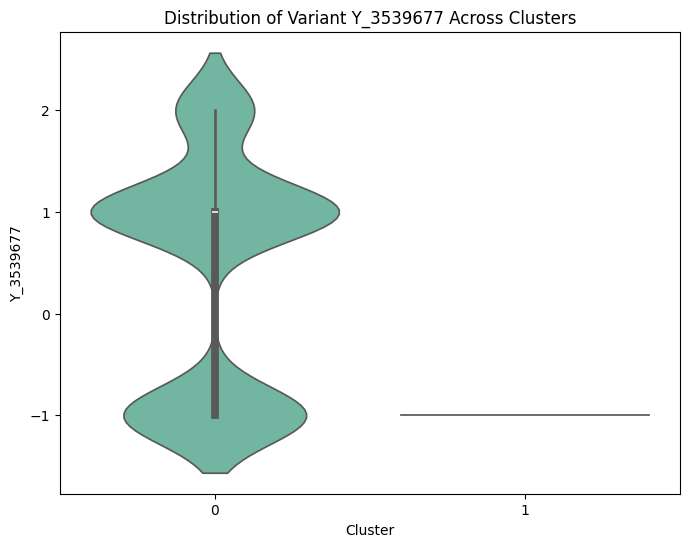

In [78]:
top_variant = X.std().sort_values(ascending=False).idxmax()
df_viz = df.copy()
df_viz["Cluster"] = clusters

plt.figure(figsize=(8, 6))
sns.violinplot(data=df_viz, x="Cluster", y=top_variant, palette="Set2")
plt.title(f"Distribution of Variant {top_variant} Across Clusters")
plt.show()

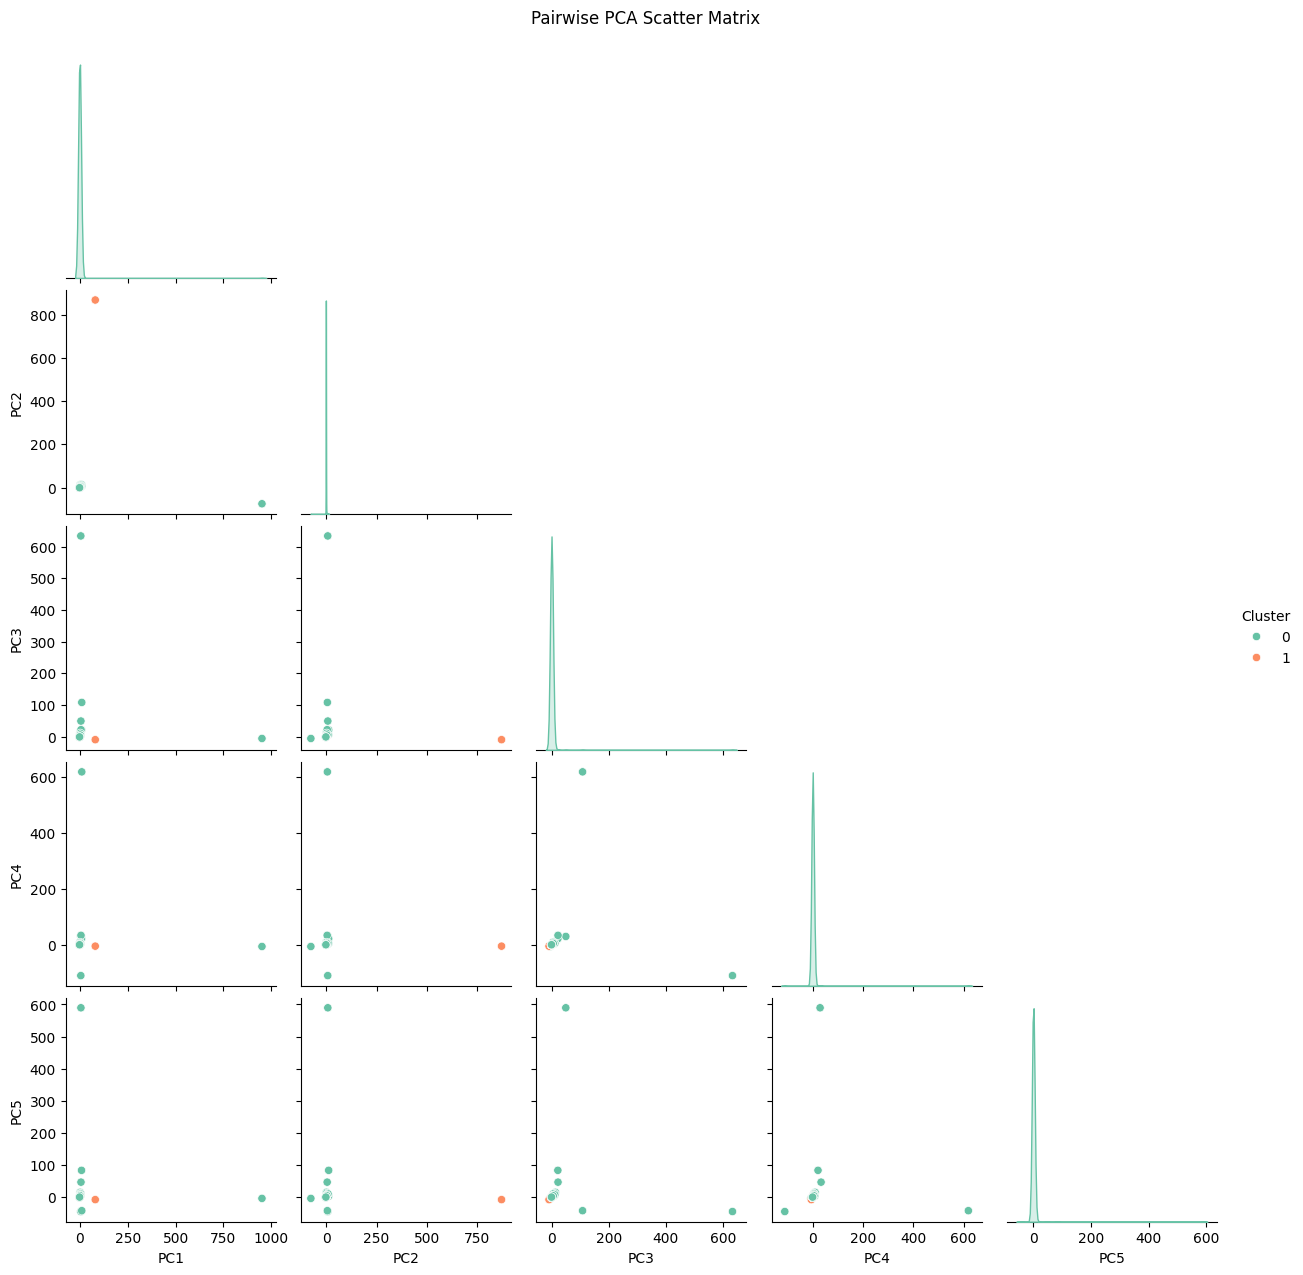

In [79]:
from pandas.plotting import scatter_matrix

pca_all = PCA(n_components=5).fit_transform(X_std)
pca_df = pd.DataFrame(pca_all, columns=[f"PC{i+1}" for i in range(5)])
pca_df["Cluster"] = clusters

# Plot pairwise scatter
sns.pairplot(pca_df, hue="Cluster", palette="Set2", corner=True)
plt.suptitle("Pairwise PCA Scatter Matrix", y=1.02)
plt.show()

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load genotype matrix
geno_df = pd.read_csv("genotype_matrix.csv")
geno_df.set_index("Sample_ID", inplace=True)

# Load variant metadata that contains variant types
var_df = pd.read_csv("parsed_variants.csv")  # Replace with actual file name
var_df["Variant_ID"] = var_df["CHROM"].astype(str) + "_" + var_df["POS"].astype(str)

# Merge type info into genotype matrix
common_variants = set(var_df["Variant_ID"]).intersection(set(geno_df.columns))
filtered_var_df = var_df[var_df["Variant_ID"].isin(common_variants)]

# Count of variant types
type_counts = filtered_var_df["Variant_Type"].value_counts()

/var/folders/xr/mk4d4gxj4xlbfps4j970493w0000gn/T/ipykernel_27622/1491048659.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  var_df = pd.read_csv("parsed_variants.csv")  # Replace with actual file name


/var/folders/xr/mk4d4gxj4xlbfps4j970493w0000gn/T/ipykernel_27622/4126448199.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette="Set2")


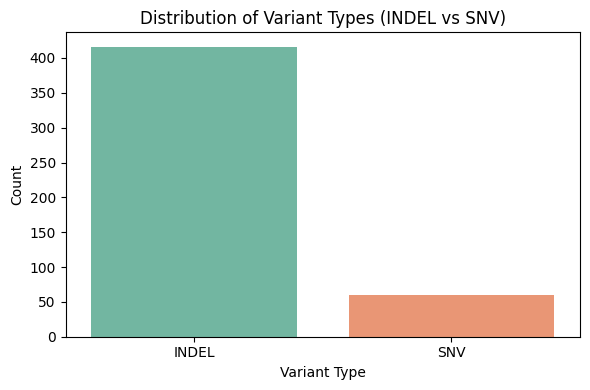

In [81]:
# Plot the counts
plt.figure(figsize=(6, 4))
sns.barplot(x=type_counts.index, y=type_counts.values, palette="Set2")
plt.title("Distribution of Variant Types (INDEL vs SNV)")
plt.ylabel("Count")
plt.xlabel("Variant Type")
plt.tight_layout()
plt.show()

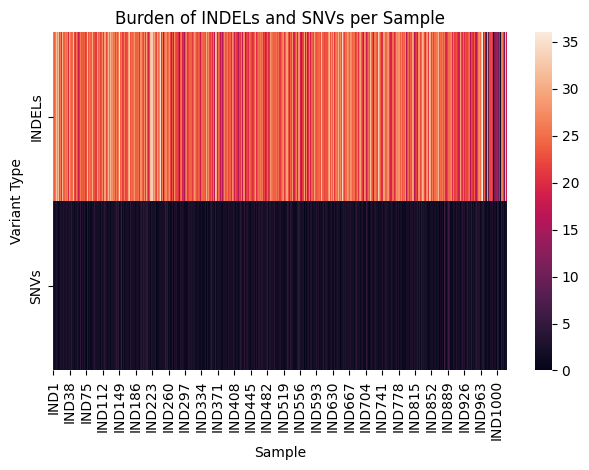

In [82]:
# Separate INDEL and SNV variant lists
indel_variants = filtered_var_df[filtered_var_df["Variant_Type"] == "INDEL"]["Variant_ID"]
snv_variants = filtered_var_df[filtered_var_df["Variant_Type"] == "SNV"]["Variant_ID"]

# Calculate burden per sample
indel_burden = geno_df[indel_variants].apply(lambda row: (row > 0).sum(), axis=1)
snv_burden = geno_df[snv_variants].apply(lambda row: (row > 0).sum(), axis=1)

# Combine for plot
burden_df = pd.DataFrame({
    "INDELs": indel_burden,
    "SNVs": snv_burden
})

# Heatmap
sns.heatmap(burden_df.T, cmap="rocket", annot=False, cbar=True)
plt.title("Burden of INDELs and SNVs per Sample")
plt.xlabel("Sample")
plt.ylabel("Variant Type")
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd

# Step 1: Load your genotype matrix
geno_df = pd.read_csv("genotype_matrix.csv")
variant_columns = [col for col in geno_df.columns if col != "Sample_ID"]

# Step 2: Load the annotated variant file (QC_filtered)
indigen_df = pd.read_excel("IndiGen_PolymorphicAlus_raw_and_QCfiltered.xlsx", sheet_name="QC_filtered", skiprows=1)

# Step 3: Rename important columns
indigen_df.rename(columns={
    indigen_df.columns[0]: "Chromosome",
    indigen_df.columns[1]: "Start",
    indigen_df.columns[2]: "End",
    indigen_df.columns[3]: "Variant_ID",
    indigen_df.columns[4]: "REF",
    indigen_df.columns[5]: "ALT",
    indigen_df.columns[6]: "TSD"
}, inplace=True)

# Step 4: Generate `Genotype_Column` for mapping
indigen_df["Genotype_Column"] = indigen_df["Chromosome"].str.replace("chr", "") + "_" + indigen_df["Start"].astype(str)

# Step 5: Filter to only variants present in your genotype matrix
matched_df = indigen_df[indigen_df["Genotype_Column"].isin(variant_columns)]

# Step 6: Select columns of interest
final_annotated = matched_df[[
    "Genotype_Column", "Variant_ID", "REF", "ALT", "TSD", "Subfamily", "RA"
]]

# Step 7: Save to CSV
final_annotated.to_csv("mapped_ALU_annotations.csv", index=False)
print(final_annotated.head())

  Genotype_Column          Variant_ID REF           ALT              TSD  \
0       1_1188985   ALU_IndiGen_ALU_2   A  <INS:ME:ALU>   AAAAATAAAACTGA   
1       1_3737487   ALU_IndiGen_ALU_7   C  <INS:ME:ALU>  GAATATGGGCTTTTC   
2       1_4011935   ALU_IndiGen_ALU_8   T  <INS:ME:ALU>        AAAATGCAT   
3       1_4228405  ALU_IndiGen_ALU_10   T  <INS:ME:ALU>  TTTTCTCACCCTTCT   
4       1_4299078  ALU_IndiGen_ALU_11   T  <INS:ME:ALU>  TGCATCTCCCTTCTT   

  Subfamily     RA  
0     AluYe  0.263  
1  AluYa1_1 -0.193  
2      AluY -0.271  
3    AluYa5 -0.054  
4     AluYb  0.640  


📥 Loading genotype matrix and RA scores...
🔗 Mapping ALU insertions to RA scores...
🧮 Computing RA-weighted scores per individual...


/var/folders/xr/mk4d4gxj4xlbfps4j970493w0000gn/T/ipykernel_67375/2036244067.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_matrix['RA_weighted_risk'] = weighted_matrix.sum(axis=1)
/var/folders/xr/mk4d4gxj4xlbfps4j970493w0000gn/T/ipykernel_67375/2036244067.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_matrix['Sample_ID'] = sample_ids
/var/folders/xr/mk4d4gxj4xlbfps4j970493w0000gn/T/ipykernel_67375/2036244067.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

💾 Saving output to 'alu_RA_risk_scores.csv'...


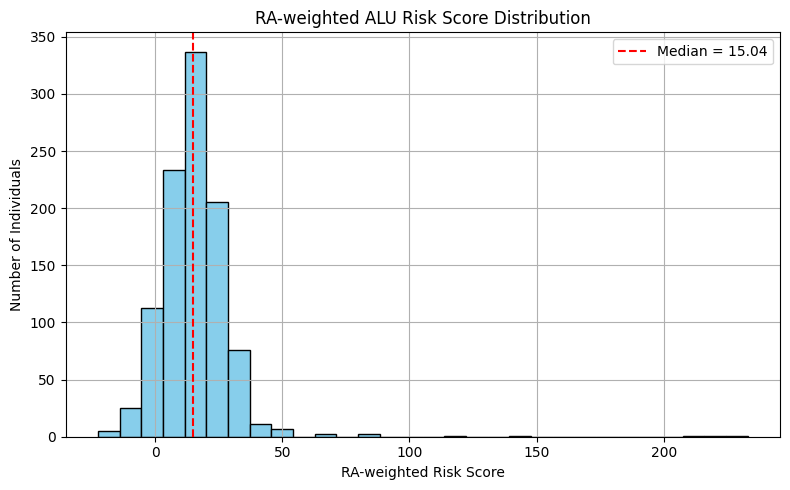

✅ Done! Results saved to:
• alu_RA_risk_scores.csv
• alu_RA_risk_histogram.png


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load data ===
print("📥 Loading genotype matrix and RA scores...")
genotype_df = pd.read_csv("genotype_matrix.csv")
ra_df = pd.read_csv("Mapped_ALU_annotations.csv")

# === Step 2: Create Variant → RA score mapping ===
print("🔗 Mapping ALU insertions to RA scores...")
ra_dict = dict(zip(ra_df['Genotype_Column'], ra_df['RA']))

# === Step 3: Compute RA-weighted scores ===
print("🧮 Computing RA-weighted scores per individual...")
sample_ids = genotype_df['Sample_ID']
X = genotype_df.drop(columns=['Sample_ID'])

# Fill missing RAs with 0 if not found
weighted_matrix = X.copy()
for col in weighted_matrix.columns:
    ra_score = ra_dict.get(col, 0)
    weighted_matrix[col] *= ra_score

# Add RA-weighted risk score column
weighted_matrix['RA_weighted_risk'] = weighted_matrix.sum(axis=1)
weighted_matrix['Sample_ID'] = sample_ids

# === Step 4: Add high/low risk labels based on median ===
median_risk = weighted_matrix['RA_weighted_risk'].median()
weighted_matrix['risk_label'] = (weighted_matrix['RA_weighted_risk'] > median_risk).astype(int)

# === Step 5: Save results ===
print("💾 Saving output to 'alu_RA_risk_scores.csv'...")
weighted_matrix[['Sample_ID', 'RA_weighted_risk', 'risk_label']].to_csv("alu_RA_risk_scores.csv", index=False)

# === Step 6: Visualize risk distribution ===
plt.figure(figsize=(8, 5))
plt.hist(weighted_matrix['RA_weighted_risk'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(median_risk, color='red', linestyle='dashed', label=f'Median = {median_risk:.2f}')
plt.title("RA-weighted ALU Risk Score Distribution")
plt.xlabel("RA-weighted Risk Score")
plt.ylabel("Number of Individuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("alu_RA_risk_histogram.png")
plt.show()

print("✅ Done! Results saved to:")
print("• alu_RA_risk_scores.csv")
print("• alu_RA_risk_histogram.png")

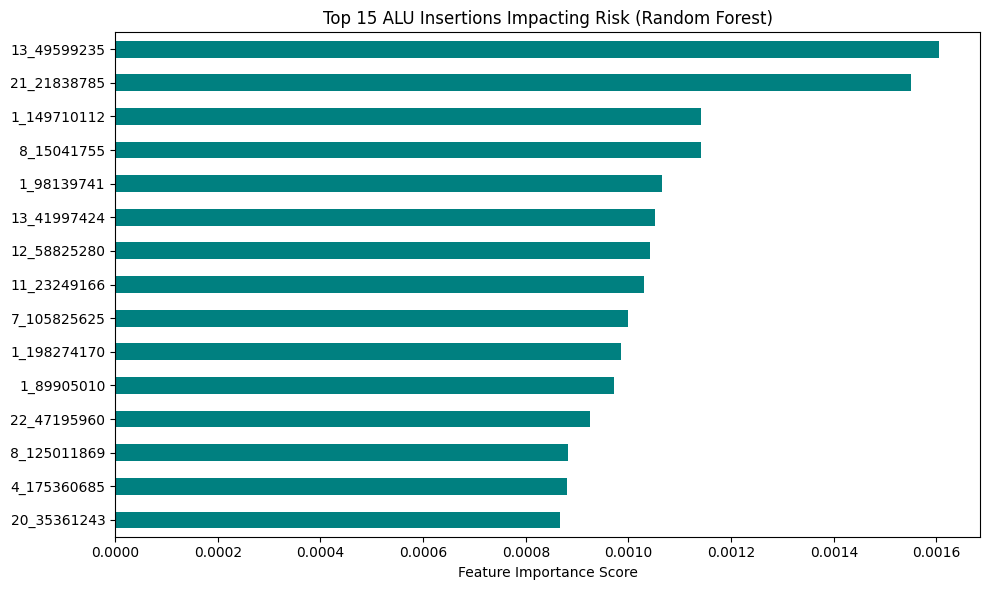

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data
X_full = pd.read_csv("genotype_matrix.csv")
X = X_full.drop(columns=["Sample_ID"])

labels_df = pd.read_csv("alu_RA_risk_scores.csv")
y = labels_df["risk_label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_rf = importances.sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
top_rf.plot(kind='barh', color='teal')
plt.gca().invert_yaxis()
plt.title("Top 15 ALU Insertions Impacting Risk (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.savefig("random_forest_feature_importance.png")
plt.show()

/opt/anaconda3/envs/genome-seq/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/genome-seq/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


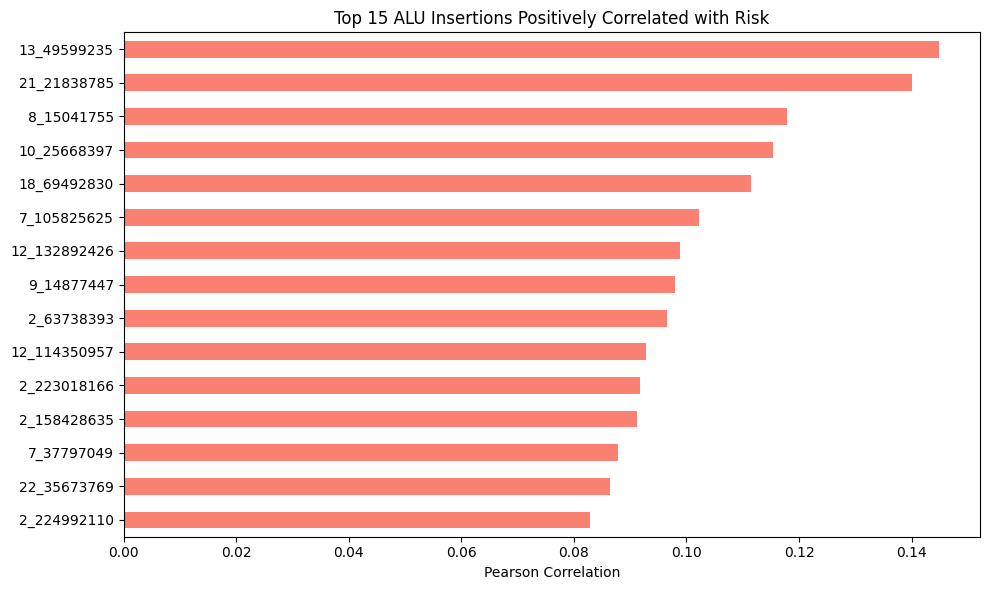

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
X_full = pd.read_csv("genotype_matrix.csv")
X = X_full.drop(columns=["Sample_ID"])

labels_df = pd.read_csv("alu_RA_risk_scores.csv")
y = labels_df["risk_label"]

# Pearson correlation
correlations = X.corrwith(y)
top_corr = correlations.sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
top_corr.plot(kind='barh', color='salmon')
plt.gca().invert_yaxis()
plt.title("Top 15 ALU Insertions Positively Correlated with Risk")
plt.xlabel("Pearson Correlation")
plt.tight_layout()
plt.savefig("correlation_feature_importance.png")
plt.show()